In [13]:
from scipy.constants import c
from scipy.special import erf
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
import iminuit
from iminuit import Minuit
from scipy.stats import truncnorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace
from scipy.integrate import quad
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


Some function definitions:

* the model calls three different velocity dispersions, so it's cleaner to have a function for them
* the los distribution is a very cut-off gaussian, so renormalizing with erf is necessary
* the log likelihood, using flat priors whose limits are defined in a long 'if' statement.

In [14]:
%%cython

from cpython.pycapsule cimport (PyCapsule_New,
                                PyCapsule_GetPointer)
from cpython.mem cimport PyMem_Malloc,  PyMem_Free
from libc.math cimport exp, sqrt
import scipy

cdef double c_integrand(double x, void* user_data):
    """The integrand, written in Cython"""
    # Extract a.
    # Cython uses array access syntax for pointer dereferencing!    
    cdef double R = (<double*>user_data)[0]
    cdef double alpha = (<double*>user_data)[1]
    cdef double r_s = (<double*>user_data)[2]
    cdef double r_t = (<double*>user_data)[3]
    
    r=x
    
    beta=4
    gamma=6
    arg=-2/alpha*((r/r_s)**alpha-1)
    coeff=(1+(r/r_t)**beta)**(-gamma/beta)
    rho_3d=exp(arg)*coeff
    
    return rho_3d*r/sqrt(r**2-R**2)

#
# Now comes some classic C-style housekeeping
#

cdef object pack_a(double R, double alpha, double r_s, double r_t):
    """Wrap 'a' in a PyCapsule for transport."""
    # Allocate memory where 'a' will be saved for the time being
    cdef double* a_ptr = <double*> PyMem_Malloc(4*sizeof(double))
    a_ptr[0] = R
    a_ptr[1] = alpha
    a_ptr[2] = r_s
    a_ptr[3] = r_t
    return PyCapsule_New(<void*>a_ptr, NULL, free_a)

cdef void free_a(capsule):
    """Free the memory our value is using up."""
    PyMem_Free(PyCapsule_GetPointer(capsule, NULL))

def get_low_level_callable(double R, double alpha, double r_s, double r_t):
    # scipy.LowLevelCallable expects the function signature to
    # appear as the "name" of the capsule
    func_capsule = PyCapsule_New(<void*>c_integrand,
                                 "double (double, void *)",
                                 NULL)
    data_capsule = pack_a(R,alpha,r_s,r_t)
    
    return scipy.LowLevelCallable(func_capsule, data_capsule)

In [15]:
@np.vectorize
def proj2d_c(alpha,r_s,r_t,R):
    c_integrand = get_low_level_callable(R,alpha,r_s,r_t)
    y, abserr = quad(c_integrand, R, np.inf)
    return 2*y

In [16]:
df_full = pd.read_pickle('paxtons_cat_with_R200m.pkl')

Text(0, 0.5, 'p($r_s$)')

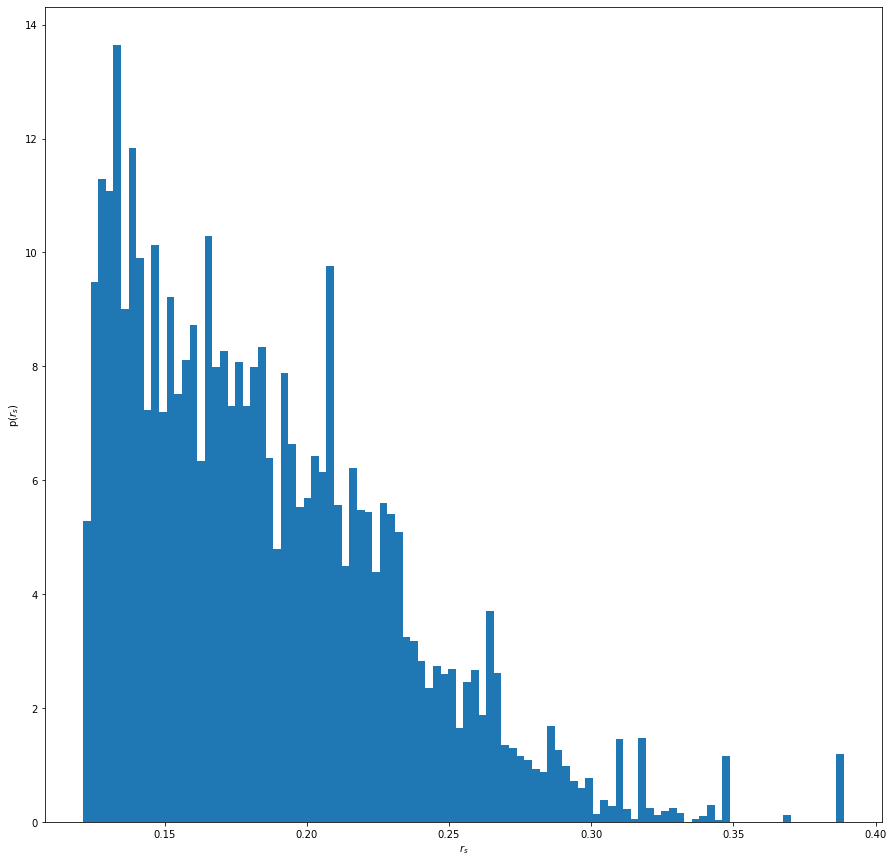

In [17]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,15))

counts, bins = np.histogram(df_full.r_s, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(df_full.r_s) / width
                                                           
ax1.bar(centers,normalized_counts,width=width)
ax1.set_xlabel('$r_s$')
ax1.set_ylabel('p($r_s$)')

In [18]:
G=4.301e-9 #km^2 Mpc Msolar^-1 s^-2
df_full['v_circ']=np.sqrt(G*df_full.M200m/df_full.R200m)

In [19]:
df_full['alpha']=0.155+0.0095*df_full.nu**2
beta=4
gamma=6
R_edge=2.2*df_full.r_lambda
k_t=1.6
r_t=R_edge/k_t

In [20]:
np.max(2.2*df_full.r_lambda)

2.7335919709139587

In [21]:
myredge=3

In [22]:
myr=np.linspace(0,myredge-1e-8,1000)

In [23]:
myalpha=np.mean(df_full.alpha)
myr_s=np.mean(df_full.r_s)

Text(0, 0.5, '$\\Sigma$')

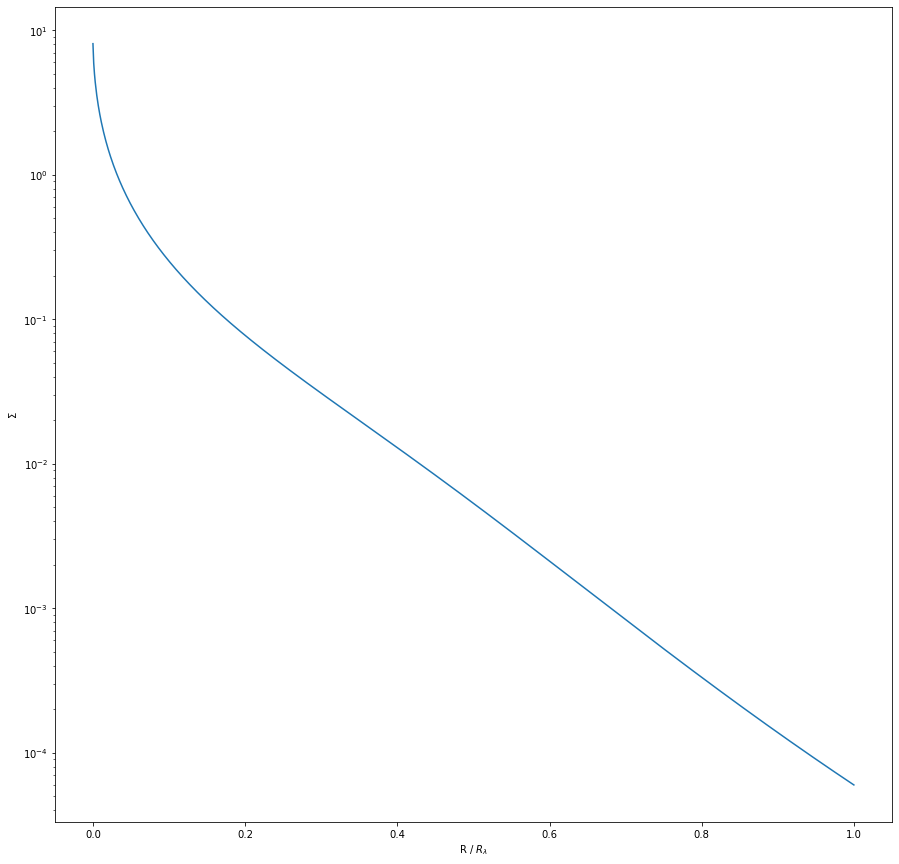

In [25]:
sol=proj2d_c(myalpha,myr_s,myredge/k_t,myr)

#ax1.scatter(df_full.r,sol)
nbins = 100
x2=myr/myredge
y2=sol

fig,ax1 = plt.subplots(1, 1,figsize=(15,15))
#ax1.plot(x, y, 'bo')
ax1.plot(x2,y2)
#plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')

ax1.set_yscale('log')
ax1.set_xlabel('R / $R_\lambda$')
ax1.set_ylabel('$\Sigma$')
#ax1.legend()

In [26]:
np.min(df_full.alpha)

0.18550261161061032

In [27]:
np.max(df_full.alpha)

0.49812580240945814

In [28]:
np.min(df_full.r_s)

0.12131493385687465

In [29]:
np.max(df_full.r_s)

0.38882741440187935

In [30]:
np.max(2.2*df_full.r_lambda*2)

5.467183941827917

In [31]:
np.min(2.2*df_full.r_lambda*2)

3.1837729986572567

In [32]:
%%time
n=200
m=20

myalpha=np.linspace(.1,.6,m)
myr_s=np.linspace(.05,.5,m)
myr_t=np.linspace(.1,7,n)
myr=np.linspace(0,6,n)

V=np.zeros((m,m,n,n))

for i in tqdm(range(m)):
    for j in range(m):
        for k in range(n):
            for l in range(n):
                ai=myalpha[i]
                rsj=myr_s[j]
                rtk=myr_t[k]
                rl=myr[l]
                
                V[i,j,k,l] = proj2d_c(myalpha[i],myr_s[j],myr_t[k],myr[l])

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 38min 26s, sys: 1.59 s, total: 38min 28s
Wall time: 39min 19s


In [33]:
import pickle

output = open('Surfaceintegral.pkl', 'wb')
pickle.dump(V, output)
output.close()

In [34]:
import pickle
pkl_file = open('Surfaceintegral.pkl', 'rb')

V = pickle.load(pkl_file)

In [76]:
points=list(zip(myalpha,myr_s,myr_t,s))1

In [35]:
from intergrid.intergrid import Intergrid

In [36]:
lo = np.array([ 0.1, .05, .1, 0 ])  # lowest lat, lowest lon
hi = np.array([ .6, .5, 7, 6 ])   # highest lat, highest lon

In [37]:
interfunc = Intergrid( V, lo=lo, hi=hi )

In [38]:
query_points = lo + np.random.uniform( size=(250000, 4) ) * (hi - lo)

In [39]:
query_values = interfunc.at( query_points )

Intergrid: 221 msec  250000 points in a (20, 20, 200, 200) grid  0 maps  order 1


Intergrid: 68.7 msec  268110 points in a (20, 20, 200, 200) grid  0 maps  order 1


Text(0, 0.5, '$\\Sigma$')

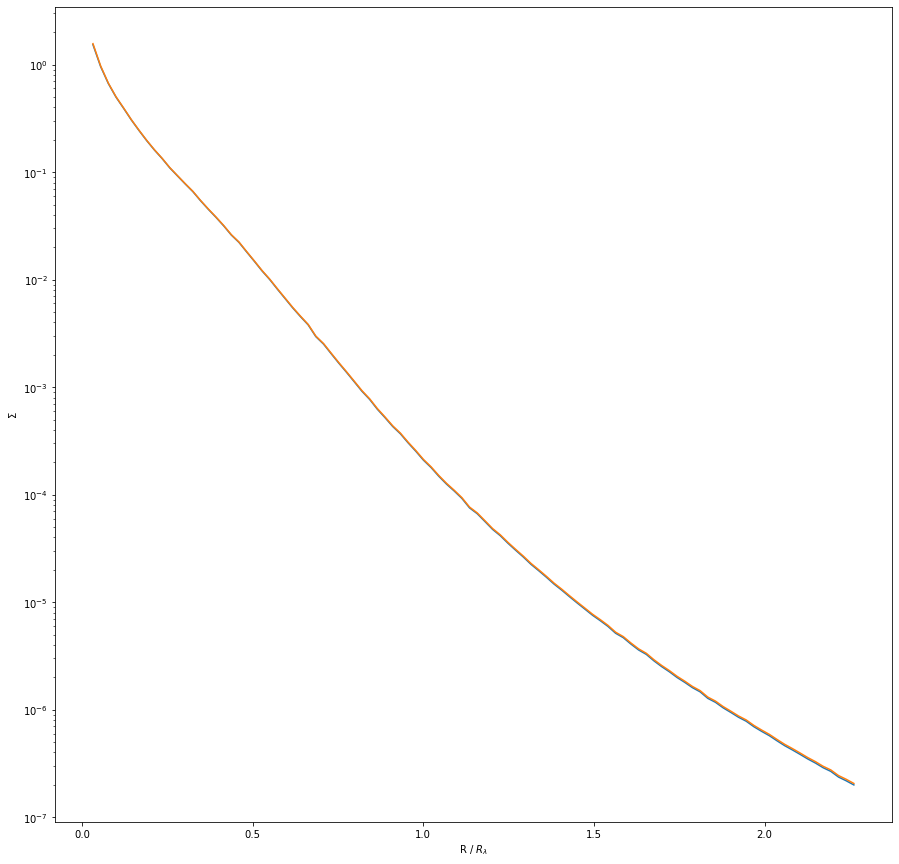

In [42]:
k_t=1.6
sol=proj2d_c(df_full.alpha,df_full.r_s,2.2*df_full.r_lambda/k_t,df_full.r)
points=list(zip(df_full.alpha,df_full.r_s,2.2*df_full.r_lambda/k_t,df_full.r))
sol2=interfunc.at( points )

#ax1.scatter(df_full.r,sol)
nbins = 100
x=df_full.r/2.2/df_full.r_lambda
y=sol

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

nbins = 100
x=df_full.r/2.2/df_full.r_lambda
y=sol2

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean2 = sy / n
std2 = np.sqrt(sy2/n - mean2*mean2)


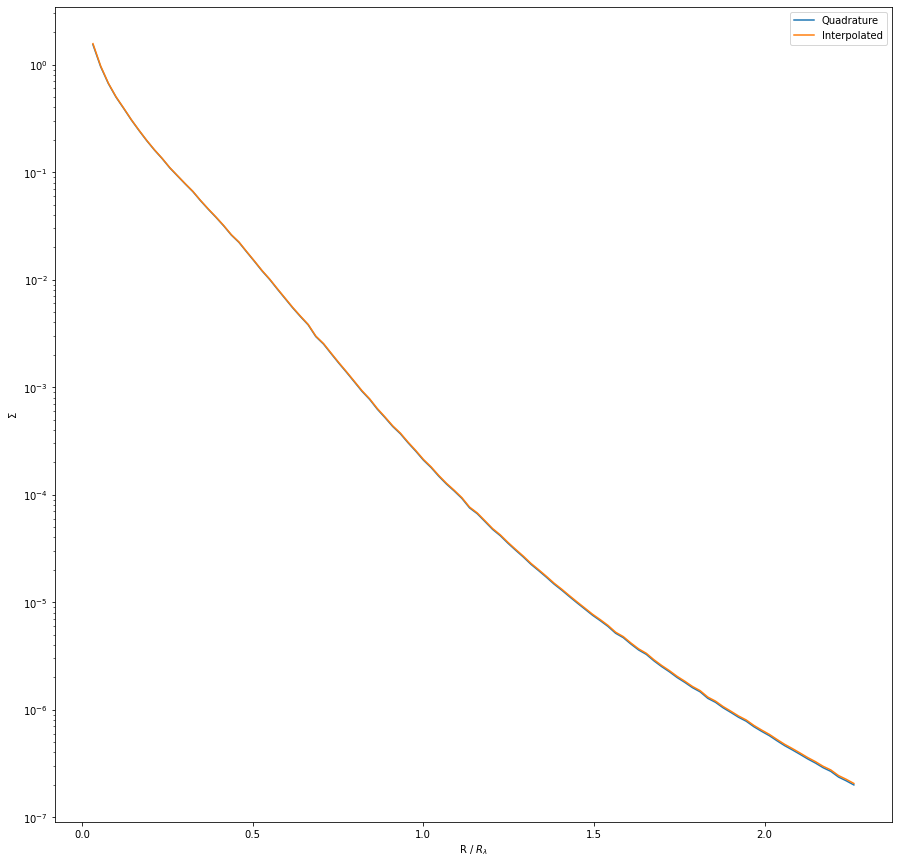

In [43]:

fig,ax1 = plt.subplots(1, 1,figsize=(15,15))
#ax1.plot(x, y, 'bo')
ax1.plot((_[1:] + _[:-1])/2, mean, label='Quadrature')
ax1.plot((_[1:] + _[:-1])/2, mean2, label='Interpolated')
#plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')

ax1.set_yscale('log')
ax1.set_xlabel('R / $R_\lambda$')
ax1.set_ylabel('$\Sigma$')
ax1.legend()

In [101]:
(mean-mean2)/mean

array([-0.02166093, -0.0143227 , -0.00967277, -0.00761773, -0.00672964,
       -0.00628013, -0.00612045, -0.00596242, -0.00591903, -0.00598466,
       -0.00603821, -0.00604994, -0.006269  , -0.00632935, -0.00674171,
       -0.00679425, -0.00699604, -0.0071825 , -0.00760067, -0.00764138,
       -0.00804836, -0.00842833, -0.00864449, -0.00908174, -0.00955435,
       -0.00992897, -0.01032129, -0.01034867, -0.01047866, -0.01141733,
       -0.01150404, -0.01188006, -0.01202809, -0.01226094, -0.01291395,
       -0.01324812, -0.01327449, -0.01405155, -0.01420782, -0.01451571,
       -0.01436873, -0.01489184, -0.0150122 , -0.01589053, -0.01564432,
       -0.01633442, -0.01648089, -0.0165307 , -0.01663196, -0.01752641,
       -0.01727717, -0.01779143, -0.0183578 , -0.01841774, -0.01881915,
       -0.01916269, -0.01949546, -0.02006738, -0.02003308, -0.0202275 ,
       -0.02109995, -0.02107344, -0.02128941, -0.02171696, -0.02208523,
       -0.02209666, -0.02225161, -0.02271163, -0.02302847, -0.02

(0.2, 3.0)

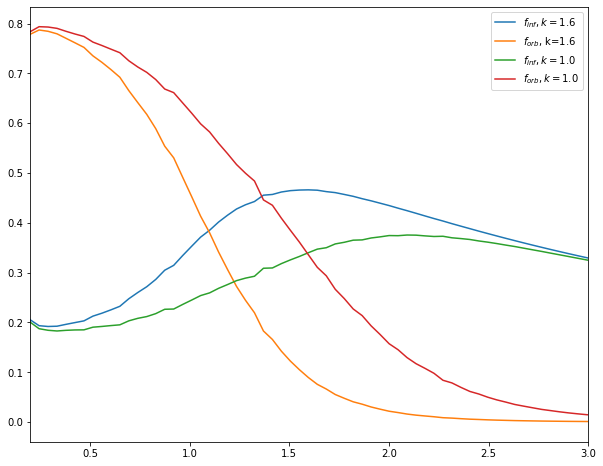

In [22]:
a1=-.3
b1=-5.14
c1=-1.5
a0=0.01
b0=0.1
c0=0.008
k_t=1.6

R_s = 0.15
R_c = 1

sol=proj2d_c(df_full.alpha,df_full.r_s,2.2*df_full.r_lambda/k_t,df_full.r,2.2*df_full.r_lambda)

nbins = 100
x=df_full.r/(2.2*df_full.r_lambda)
y=sol*2.2*df_full.r_lambda

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
RonRedge=(_[1:] + _[:-1])/2

S_orb=mean
S_los=a0*RonRedge**a1
S_inf=c0*RonRedge**c1

total=S_los+S_inf+S_orb

A_orb=S_orb/total
A_inf=S_inf/total
A_los=S_los/total

f_da=A_inf+A_orb
f_orb=A_orb/(A_inf+A_orb)
f_inf=f_da-f_orb

fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

ax1.plot(2*RonRedge,A_inf,label='$f_{inf}, k=1.6$')
ax1.plot(2*RonRedge,A_orb,label='$f_{orb}$, k=1.6')

k_t=1.0

R_s = 0.15
R_c = 1

sol=proj2d_c(df_full.alpha,df_full.r_s,2.2*df_full.r_lambda/k_t,df_full.r,2.2*df_full.r_lambda)

nbins = 100
x=df_full.r/(2.2*df_full.r_lambda)
y=sol*2.2*df_full.r_lambda

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
RonRedge=(_[1:] + _[:-1])/2

S_orb=mean
S_los=a0*RonRedge**a1
S_inf=c0*RonRedge**c1

total=S_los+S_inf+S_orb

A_orb=S_orb/total
A_inf=S_inf/total
A_los=S_los/total

f_da=A_inf+A_orb
f_orb=A_orb/(A_inf+A_orb)
f_inf=f_da-f_orb

ax1.plot(2*RonRedge,A_inf,label='$f_{inf}, k=1.0$')
ax1.plot(2*RonRedge,A_orb,label='$f_{orb}, k=1.0$')
ax1.legend()
ax1.set_xlim([0.2,3.0])